In [1]:
import torch
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda NVIDIA GeForce RTX 3060


In [4]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [5]:
# Hyper Parameters for DQN
BATCH_SIZE = 128            # training batch
LR = 0.01                   # learning rate
EPSILON = 0.9               # greedy policy
GAMMA = 0.9                 # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
MEMORY_CAPACITY = 10000
N_ACTIONS = 1001    # 1000 values
N_STATES = 2        # [set value, process output value]

In [6]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 50).cuda()
        self.fc1.weight.data.normal_(0, 0.1)   # initialization
        self.out = nn.Linear(50, N_ACTIONS).cuda()
        self.out.weight.data.normal_(0, 0.1)   # initialization

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value

In [7]:
class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0).cuda()
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].cpu().data.numpy()
            action = action[0]  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action 
        return action

    def take_action(self, a): # 0~1000 * 0.01 = 0 to 10
        value = a*0.01
        return value
    
    def reward(self, s):  # s = [set_value, process_output]
        error = abs(s[1] -s[0]) # process_output - set_value
        r = -(error**2)*1000
        return r
    
    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES]).cuda()
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int)).cuda()
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2]).cuda()
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:]).cuda()

        # q_eval w.r.t the action in experience
        q_eval = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [8]:
dqn = DQN()

# Connect to Unity

In [9]:
from mlagents_envs.environment import UnityEnvironment

In [10]:
env = UnityEnvironment(file_name= None, base_port=5004)

In [11]:
env.reset()

In [13]:
env.close()

# start tensorboard to record training data

In [12]:
# 此行顯示目前這個 ipython notebook 的目錄
!echo The current directory is %CD%

The current directory is C:\Users\ADMIN\Dropbox\(0) AI 教學, 演講\(1) PyTorch 程式\3. RL\3.1. DQN\1. DQN-Process control


In [ ]:
# 在 python terminal window, 到這個 ipython notebook 的目錄下輸入:
# tensorboard --logdir=runs

In [ ]:
# 網頁 localhost:6006 連到 TB server

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [10]:
ep_rLst = []
start_episode = 5000
end_episode = start_episode + 5001
for i_episode in range(start_episode, end_episode):
    sv[0:] = np.random.uniform(3.0, 7.0)
    p_out[0:] = np.random.uniform(0.1, 8)
    
    print(i_episode, end=', ')
    ep_r = 0
    
    # initialize environment to create the first state
    s = [sv[0], p_out[0]]  # state = [set_value, process_output]    
    for i in range(0, ns): # run control steps
        # as a benchmark, calculate output from unit step 
        y = odeint(process, p_out_unit_step[i],[0,delta_t],args=(sv[i],KP,TAUP))
        p_out_unit_step[i+1] = y[-1][0]
        
        # Q-learning
        a = dqn.choose_action(s)         # choose action index 0~1000
        action[i] = dqn.take_action(a)   # 0~1000 * 0.01 = 0~10 
        y = odeint(process, p_out[i],[0,delta_t],args=(action[i]+noise[i],KP,TAUP))
        p_out[i+1] = y[-1][0]
        s_ = [sv[i+1], p_out[i+1]]   # next state
        r = dqn.reward(s_)  
        dqn.store_transition(s, a, r, s_)
        ep_r += r
        reward[i] = r
        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()
        s = s_

    # finish one episode 
    if(i_episode % 100 == 0):  #save the DQN and its performance plot every 100 episode
        fig=plt.figure(figsize=(32,18)) 
        plt.subplot(3, 1, 1)  # 3 rows, 1 column
        plt.plot(sv, 'r', lw =2, label='Set Value')
        plt.plot(p_out, 'b--', lw =1, label='Process Value')
        plt.plot(p_out_unit_step, 'k--', lw =1, label='ODE Unit Step Output')
        plt.legend(loc = 'best')
        plt.xlabel('Time')
        plt.ylim(0,10.0)
        plt.xlim(0,ns)
        plt.text(0.5, 0.1, 'Ep_r=%.2f' % ep_r, fontdict={'size':10, 'color': 'blue'})
        plt.grid(True)
        
        plt.subplot(3, 1, 2)  
        plt.plot(action, 'k--', lw =1, label='RL Controller Output')
        plt.plot(noise, 'r', lw =1, label='Noise')    
        plt.legend(loc = 'best')
        plt.xlabel('Time')
        plt.ylim(0,10.0)
        plt.xlim(0,ns)
        plt.text(0.5, 0.1, 'Ep_r=%.2f' % ep_r, fontdict={'size':10, 'color': 'blue'})
        plt.grid(True)

        plt.subplot(3, 1, 3)  
        plt.plot(reward, 'b', lw =1, label='Reward')
        plt.legend(loc = 'best')
        plt.xlabel('Time')
        plt.xlim(0,ns)
        plt.grid(True)    
        
        Imgfname = path+'Episode_'+ str(i_episode)  
        plt.savefig(Imgfname)
        plt.close(fig)    # close the figure
        
    if(i_episode % 500 == 0):  #save the DQN and its performance plot every 500 episods
        DQNfname = path+'DQN_Episode_'+str(i_episode)+'.pkl'
        torch.save(dqn.eval_net.state_dict(), DQNfname) # parameters
    ep_r = round(ep_r, 2)
    ep_rLst.append(ep_r)

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222

1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717

2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083

4283, 4284, 4285, 4286, 4287, 4288, 4289, 4290, 4291, 4292, 4293, 4294, 4295, 4296, 4297, 4298, 4299, 4300, 4301, 4302, 4303, 4304, 4305, 4306, 4307, 4308, 4309, 4310, 4311, 4312, 4313, 4314, 4315, 4316, 4317, 4318, 4319, 4320, 4321, 4322, 4323, 4324, 4325, 4326, 4327, 4328, 4329, 4330, 4331, 4332, 4333, 4334, 4335, 4336, 4337, 4338, 4339, 4340, 4341, 4342, 4343, 4344, 4345, 4346, 4347, 4348, 4349, 4350, 4351, 4352, 4353, 4354, 4355, 4356, 4357, 4358, 4359, 4360, 4361, 4362, 4363, 4364, 4365, 4366, 4367, 4368, 4369, 4370, 4371, 4372, 4373, 4374, 4375, 4376, 4377, 4378, 4379, 4380, 4381, 4382, 4383, 4384, 4385, 4386, 4387, 4388, 4389, 4390, 4391, 4392, 4393, 4394, 4395, 4396, 4397, 4398, 4399, 4400, 4401, 4402, 4403, 4404, 4405, 4406, 4407, 4408, 4409, 4410, 4411, 4412, 4413, 4414, 4415, 4416, 4417, 4418, 4419, 4420, 4421, 4422, 4423, 4424, 4425, 4426, 4427, 4428, 4429, 4430, 4431, 4432, 4433, 4434, 4435, 4436, 4437, 4438, 4439, 4440, 4441, 4442, 4443, 4444, 4445, 4446, 4447, 4448, 4449

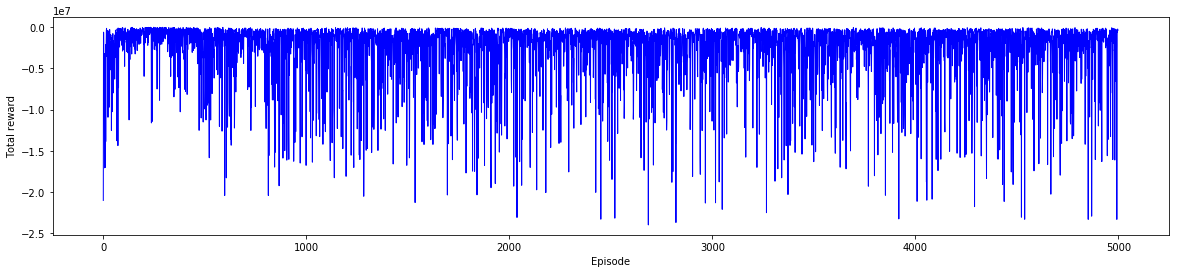

In [17]:
plt.figure(figsize=(20,4)) 
plt.plot(ep_rLst, 'b', lw =1)
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()